In [19]:
import sys
import collections
collections.Iterable = collections.abc.Iterable
from angler import Optimization, Simulation
from angler import two_port
import matplotlib.pylab as plt
import numpy as np
import torch
import meep as mp

In [20]:
cell = mp.Vector3(16,8,0)
geometry = [mp.Block(mp.Vector3(mp.inf,1,mp.inf),
                     center=mp.Vector3(),
                     material=mp.Medium(epsilon=12))]
sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                     component=mp.Ez,
                     center=mp.Vector3(-7,0))]
pml_layers = [mp.PML(1.0)] #1um
resolution = 10 #pixels per micron

In [21]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

In [22]:
sim.run(until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000197887 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.024152 s
-----------
run 0 finished at t = 200.0 (4000 timesteps)


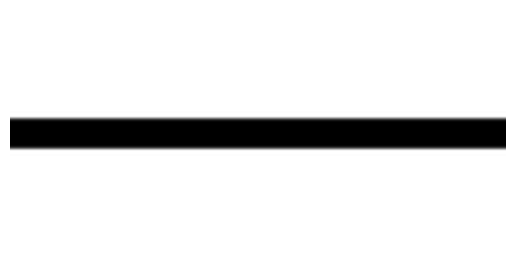

In [23]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')
plt.show()

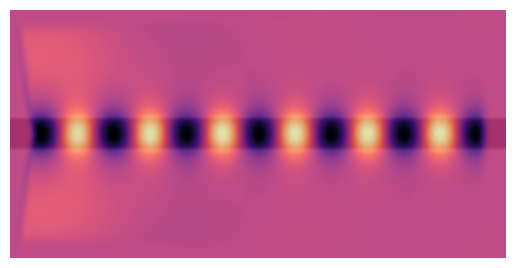

In [24]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='magma', alpha=0.9)
plt.axis('off')
plt.show()

In [25]:
lambda0=(1/0.15)*1e-6
c0 = 3e8 
omega=0.15*2*np.pi*c0/(1e-6)
dl=0.1
#dl = 0.04                   # grid size (L0)
NPML = [resolution, resolution]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1              # amplitude of modal source (A/L0^2?)

In [26]:
L = 12         # length of box (L0)
H = 5.8        # height of box (L0)
w = 1        # width of waveguides (L0)
l = 1         # length of waveguide from PML to box (L0)
spc = 0.1       # space between box and PML (L0)
eps_m=12
print(eps_data)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


160 80
Computed a domain with 160 grids in x and 80 grids in y
The simulation has 66 grids per free space wavelength


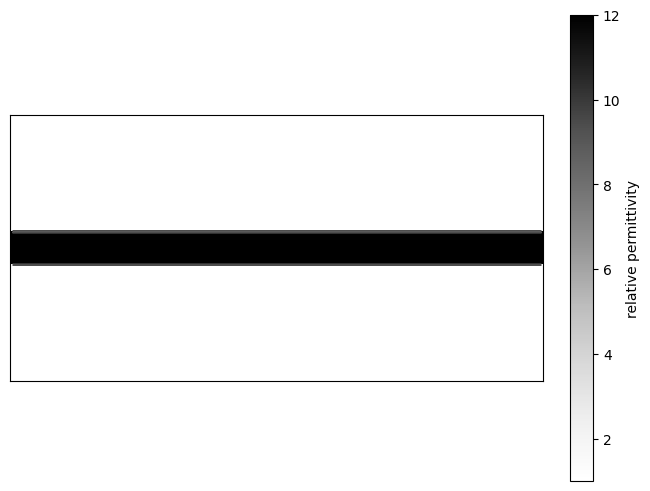

In [27]:
# define permittivity of three port system
eps_r, design_region = two_port(L, H, w, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
print(Nx,Ny)
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,grid_step,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [28]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/3), scale=source_amp)
simulation.setup_modes()

# top modal profile
out = Simulation(omega, eps_r, dl, NPML, 'Ez')
out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
out.setup_modes()
J_out = np.abs(out.src)

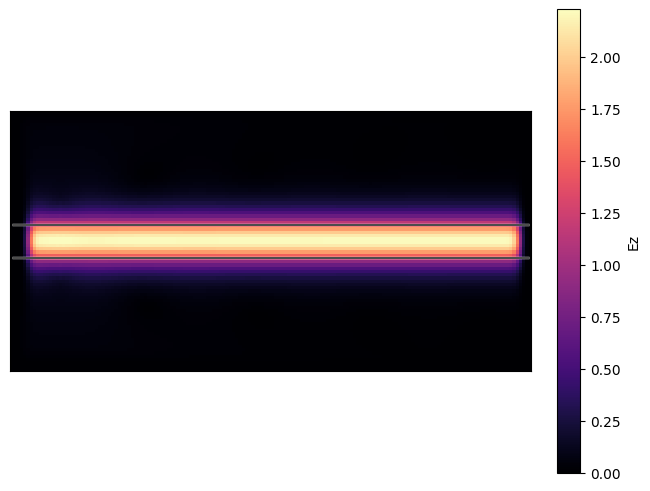

In [29]:
# set source and solve for electromagnetic fields
(_, _, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);